# XAI for Sea Ice Classification of Waveform

This notebook demonstrates techniques for classifying sea ice and leads from waveform data using both deep learning and tree-based methods and the ways to show which part of the waveform contributes the most to the classification.

## Models Implemented

- **CNN**: Captures patterns directly from raw waveforms  
- **Random Forest**: Robust ensemble approach with inherent feature importance  
- **Gradient Boosting**: Sequential learning focused on misclassification correction  
- **XGBoost**: Optimized gradient boosting with regularization  

## Key Analysis Techniques

- Consistent preprocessing of variable-length waveforms  
- Feature importance visualization overlaid on waveform patterns  
- SHAP values for CNN interpretability  
- Model comparison with confusion matrices

The notebook identifies which parts of radar waveforms are most discriminative for sea ice classification, offering insights that may improve for waveform classification.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Preprocessing

- Reads waveform data from a CSV file and processes it into structured arrays.  
- Parses waveforms from string representations and ensures uniform length through truncation or zero-padding.  
- Handles missing values and class label inconsistencies.  
- Splits data into training and test sets while scaling features for consistency.  
- Visualizes class distributions and waveform patterns for exploratory analysis.  

---

## 2. CNN Model for Waveform Classification

- Implements a 1D Convolutional Neural Network (CNN) to classify sea ice and leads from radar waveforms.  
- Uses multiple convolutional layers with batch normalization, max pooling, dropout, and dense layers.  
- Compiles with the Adam optimizer and binary cross-entropy loss, monitoring performance with accuracy and AUC metrics.  
- Trains with early stopping and learning rate reduction strategies to prevent overfitting.  
- Plots training history to assess model performance over epochs.  

---

## 3. Model Evaluation & Explainability (SHAP & Gradients)

- Evaluates the trained CNN model on the test set, reporting accuracy, confusion matrix, and classification metrics.  
- Uses **SHAP (SHapley Additive Explanations)** values to interpret feature importance, identifying key waveform regions influencing classification.   
- Helps in understanding which waveform characteristics contribute most to sea ice classification decisions.  


       3A=0_3B=1  Orbit_#  Segment_#     Datenumber   Latitude  Longitude  \
0              0        1          1  738977.028790  74.432732 -73.103512   
1              0        1          1  738977.028790  74.435182 -73.109831   
2              0        1          1  738977.028791  74.437633 -73.116151   
3              0        1          1  738977.028791  74.440083 -73.122474   
4              0        1          1  738977.028792  74.442533 -73.128797   
...          ...      ...        ...            ...        ...        ...   
28720          0      843        843  739006.699439  71.763165 -74.486482   
28721          0      843        843  739006.699440  71.760574 -74.491177   
28722          0      843        843  739006.699440  71.757982 -74.495872   
28723          0      843        843  739006.699450  71.711313 -74.580159   
28724          0      843        843  739006.699451  71.708719 -74.584830   

       Radar_Freeboard  Surface_Height_WGS84  Sea_Surface_Height_Interp_WGS

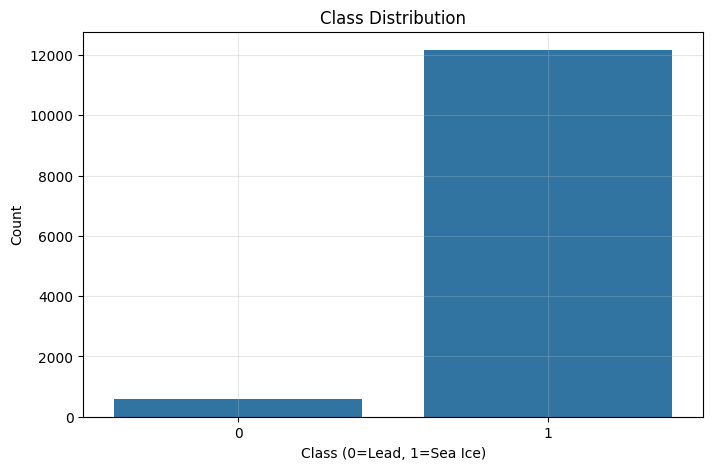

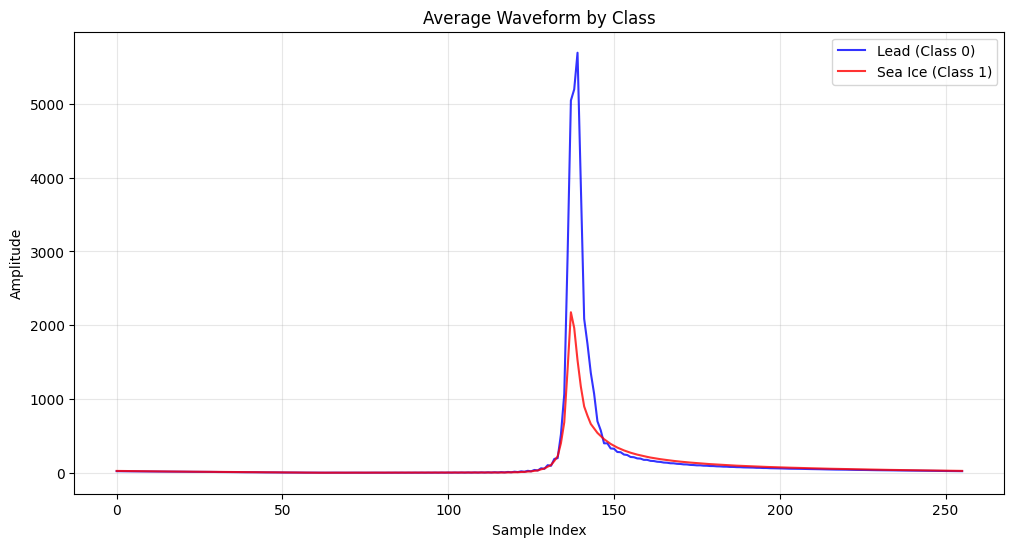

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import ast

roughness = pd.read_csv('/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder20242025/Week 9/updated_filtered_matched_uit_sentinel3_L2_alongtrack_2023_04_official.txt')
print(roughness)

# ----- 1. Data Preprocessing -----

# Function to parse string representation of waveform array into numeric values
def parse_waveform(waveform_str):
    """Parse the string representation of waveform array into numeric values"""
    cleaned_str = waveform_str.replace('e+', 'e').replace(' ', '')

    try:
        # Use ast.literal_eval for safe evaluation of the string as a list
        waveform_list = ast.literal_eval(cleaned_str)
        return np.array(waveform_list)
    except (SyntaxError, ValueError) as e:
        try:
            # Manual parsing fallback
            values_str = waveform_str.strip('[]').split(',')
            values = []
            for val in values_str:
                val = val.strip()
                if val:  # Skip empty strings
                    values.append(float(val))
            return np.array(values)
        except Exception as e2:
            print(f"Error parsing waveform: {e2}")
            return np.array([])


def roll_waveform(waveform):
    n_bins = waveform.shape[0]
    rolled_waveform = np.zeros_like(waveform)

    # Find the first bin that is 10x higher than all previous bins
    target_bin = None
    for j in range(1, n_bins):
        if waveform[j] >= 10 * np.mean(waveform[:j]):
            target_bin = j
            break

    # print('target_bin',target_bin)
    # If no such bin is found, keep the waveform unchanged
    if target_bin is None:
        rolled_waveform = waveform
    else:
        # Roll the waveform to place the target_bin in the center
        center_bin = n_bins // 2
        shift = center_bin - target_bin
        rolled_waveform = np.roll(waveform, shift)

    return rolled_waveform

# Extract waveforms and prepare data
print("Processing waveforms and extracting class labels...")

# Sample one waveform to determine expected length
sample_idx = 0
while True:
    try:
        sample_waveform = parse_waveform(str(roughness['Matched_Waveform_20_Ku'].iloc[sample_idx]))
        if len(sample_waveform) > 0:
            expected_length = len(sample_waveform)
            print(f"Expected waveform length: {expected_length}")
            break
        sample_idx += 1
    except:
        sample_idx += 1

    if sample_idx >= len(roughness):
        print("Could not determine expected waveform length. Using 256 as default.")
        expected_length = 256
        break

target_column = 'Sea_Ice_Class'

# Check if target exists
if target_column not in roughness.columns:
    print(f"Warning: {target_column} not found. Available columns: {roughness.columns}")
    print("Will use 'Lead_Class' as target instead.")
    target_column = 'Lead_Class'

# Process waveforms and extract class labels
X_list = []
y_list = []
valid_indices = []

for idx, row in roughness.iterrows():
    if idx % 500 == 0:
        print(f"Processing row {idx}/{len(roughness)}...")

    try:
        waveform_str = str(row['Matched_Waveform_20_Ku'])
        waveform_array = parse_waveform(waveform_str)
        rolled_waveform_array = roll_waveform(waveform_array)
        # print('max ',np.max(waveform_array), np.max(rolled_waveform_array), waveform_array.shape, rolled_waveform_array.shape)

        class_label = int(row[target_column])

        if len(waveform_array) > 0:
            if len(waveform_array) > expected_length:
                waveform_array = waveform_array[:expected_length]  # Truncate
                rolled_waveform_array = roll_waveform(waveform_array)

            elif len(waveform_array) < expected_length:
                padded = np.zeros(expected_length)
                padded[:len(waveform_array)] = waveform_array  # Pad with zeros
                waveform_array = padded
                rolled_waveform_array = roll_waveform(waveform_array)

            # Append
            # X_list.append(waveform_array)
            X_list.append(rolled_waveform_array)
            y_list.append(class_label)
            valid_indices.append(idx)
    except Exception as e:
        if idx < 5:  # Print first few errors
            print(f"Error processing row {idx}: {e}")
        continue




# Convert to numpy arrays
print(f"Creating numpy array with {len(X_list)} waveforms of length {expected_length}...")
X = np.stack(X_list)  # Use stack instead of array for potentially inconsistent shapes
y = np.array(y_list)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for NaN values and remove them
nan_mask_X = np.isnan(X).any(axis=1)
nan_mask_y = np.isnan(y)
nan_mask = nan_mask_X | nan_mask_y
X_clean = X[~nan_mask]
y_clean = y[~nan_mask]

print(f"Removed {np.sum(nan_mask)} samples with NaN values")
print(f"Processed {len(X_clean)} valid waveforms")
print(f"Waveform shape: {X_clean.shape}")
print(f"Class distribution: {np.bincount(y_clean)}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y_clean)
plt.title('Class Distribution')
plt.xlabel('Class (0=Lead, 1=Sea Ice)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Visualize average waveforms by class
plt.figure(figsize=(12, 6))

waveforms_class0 = X_clean[y_clean == 0]
waveforms_class1 = X_clean[y_clean == 1]


# align echoes


if len(waveforms_class0) > 0:
    plt.plot(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.8)
if len(waveforms_class1) > 0:
    plt.plot(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.8)

plt.title('Average Waveform by Class')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [45]:
class_label

1

In [44]:
X_list[100].shape

(256,)

In [39]:
waveforms_class1.shape

(12161, 256)

In [51]:
# import numpy as np

# # Simulated data (replace with your actual waveforms_class1)
# # waveforms_class1 = np.random.rand(12161, 256)



# def roll_waveforms(waveforms):
#     n_waveforms, n_bins = waveforms.shape
#     rolled_waveforms = np.zeros_like(waveforms)

#     for i in range(n_waveforms):
#         waveform = waveforms[i]

#         # Find the first bin that is 10x higher than all previous bins
#         target_bin = None
#         for j in range(1, n_bins):
#             if waveform[j] >= 10 * np.mean(waveform[:j]):
#                 target_bin = j
#                 break

#         # If no such bin is found, keep the waveform unchanged
#         if target_bin is None:
#             rolled_waveforms[i] = waveform
#         else:
#             # Roll the waveform to place the target_bin in the center
#             center_bin = n_bins // 2
#             shift = center_bin - target_bin
#             rolled_waveforms[i] = np.roll(waveform, shift)

#     return rolled_waveforms

# # Apply the function
# rolled_waveforms_class1 = roll_waveforms(waveforms_class1)
# rolled_waveforms_class0 = roll_waveforms(waveforms_class0)

# # Check the result
# print("Original shape:", waveforms_class1.shape)
# print("Rolled shape:", rolled_waveforms_class1.shape)


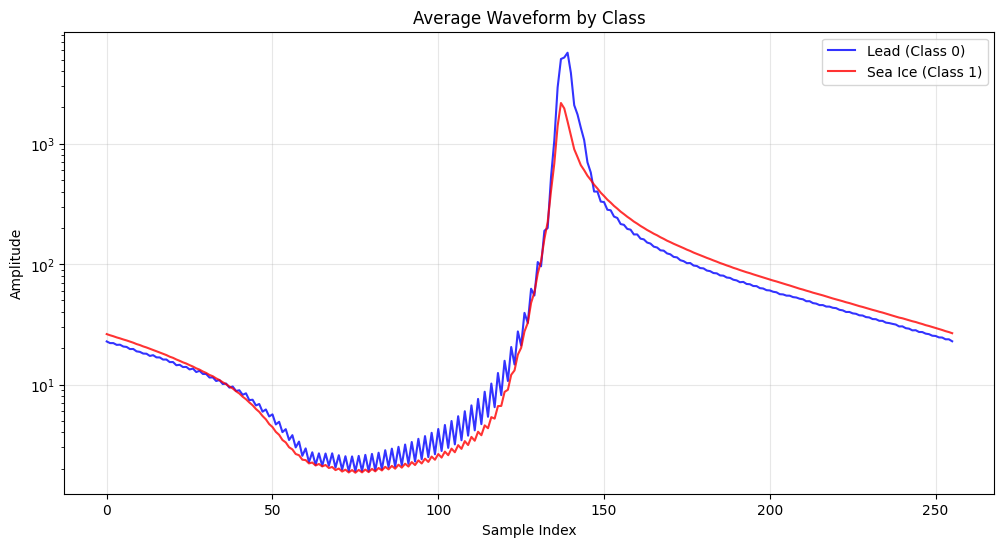

In [52]:
# Visualize average waveforms by class
plt.figure(figsize=(12, 6))
# waveforms_class0 = X_clean[y_clean == 0]
# waveforms_class1 = X_clean[y_clean == 1]

if len(waveforms_class0) > 0:
    plt.semilogy(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.8)
if len(waveforms_class1) > 0:
    plt.semilogy(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.8)

plt.title('Average Waveform by Class')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 252, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 252, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 126, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 122, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 122, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 59, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 59, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3712)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         475,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520,193 (1.98 MB)

 Trainable params: 519,489 (1.98 MB)

 Non-trainable params: 704 (2.75 KB)


Training CNN model for classification...
Detected class imbalance, applying class weights
Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.7486 - auc: 0.8403 - loss: 0.5536 - val_accuracy: 0.9643 - val_auc: 0.8013 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8010 - auc: 0.8933 - loss: 0.4014 - val_accuracy: 0.7876 - val_auc: 0.8692 - val_loss: 0.2506 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7669 - auc: 0.9111 - loss: 0.3802 - val_accuracy: 0.7347 - val_auc: 0.9439 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7684 - auc: 0.9181 - loss: 0.3579 - val_accuracy: 0.7381 - val_auc: 0.9457 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7823 - auc: 0.9086 - loss: 0.3699 - val_accuracy: 0.8468 - val_auc: 0.9451 - val_loss: 0.3019 - learning

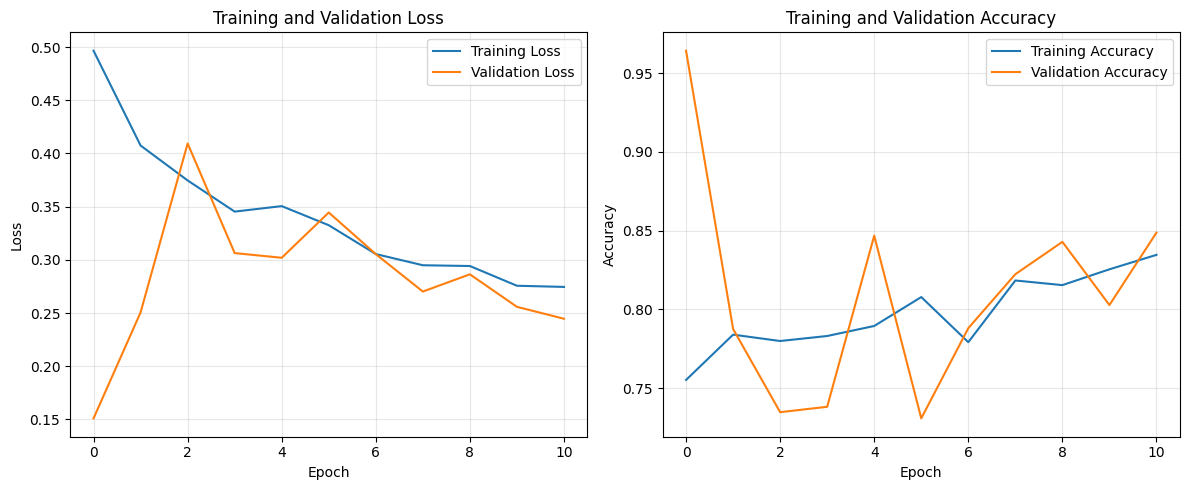

In [53]:
# ----- 2. CNN Model for Waveform Classification -----

# Reshape data for CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build the CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        # First convolutional block
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Second convolutional block
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Third convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Flatten and dense layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

# Create and compile model
model = build_cnn_model((X_train_cnn.shape[1], 1))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

# Train the model
print("\nTraining CNN model for classification...")
class_weights = None
# Check if classes are imbalanced and create class_weights if needed
if len(np.unique(y_train)) > 1:
    n_samples = len(y_train)
    n_classes = len(np.unique(y_train))
    class_counts = np.bincount(y_train)
    if np.min(class_counts) / np.max(class_counts) < 0.5:  # If imbalanced
        print("Detected class imbalance, applying class weights")
        class_weights = {i: n_samples / (n_classes * count) for i, count in enumerate(class_counts)}

history = model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Accuracy: 0.9569

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.12      0.20       121
           1       0.96      1.00      0.98      2432

    accuracy                           0.96      2553
   macro avg       0.89      0.56      0.59      2553
weighted avg       0.95      0.96      0.94      2553



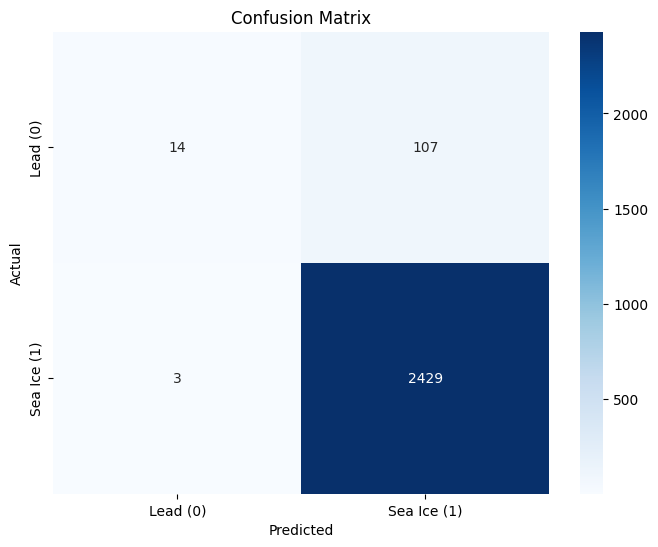


Calculating feature importance using SHAP values...
Using SHAP permutation explainer with 513 evaluations
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


PermutationExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PermutationExplainer explainer:   8%|▊         | 4/50 [00:20<02:15,  2.94s/it]

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  10%|█         | 5/50 [00:28<03:49,  5.11s/it]

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PermutationExplainer explainer:  12%|█▏        | 6/50 [00:35<04:15,  5.82s/it]

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PermutationExplainer explainer:  14%|█▍        | 7/50 [00:43<04:43,  6.59s/it]

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PermutationExplainer explainer:  16%|█▌        | 8/50 [00:48<04:20,  6.20s/it]

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PermutationExplainer explainer:  18%|█▊        | 9/50 [00:55<04:25,  6.47s/it]

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# ----- Model Evaluation -----

# Make predictions
y_pred_prob = model.predict(X_test_cnn).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lead (0)', 'Sea Ice (1)'],
            yticklabels=['Lead (0)', 'Sea Ice (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ----- SHAP Feature Importance Analysis -----

print("\nCalculating feature importance using SHAP values...")

try:
    # For SHAP analysis we need to reshape our data to 2D (removing the channel dimension)
    # For CNN this means flattening the last dimension if needed
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    X_train_2d = X_train.reshape(X_train.shape[0], -1)

    # Use a subset of the data for computational efficiency
    n_train_samples = min(200, len(X_train_2d))
    n_test_samples = min(50, len(X_test_2d))

    def model_predict(x):
        x_reshaped = x.reshape(-1, x.shape[1], 1)
        return model.predict(x_reshaped)

    num_features = X_test_2d.shape[1]
    min_evals = 2 * num_features + 1

    explainer = shap.Explainer(model_predict,
                              X_train_2d[:n_train_samples],
                              algorithm="permutation",
                              max_evals=min_evals)

    print(f"Using SHAP permutation explainer with {min_evals} evaluations")
    shap_values = explainer(X_test_2d[:n_test_samples])

    def plot_importance_on_waveform(feature_importance, model_name, X_clean, y_clean):
        plt.figure(figsize=(15, 6))

        # Plot average waveforms
        waveforms_class0 = X_clean[y_clean == 0]
        waveforms_class1 = X_clean[y_clean == 1]

        if len(waveforms_class0) > 0:
            plt.plot(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.5)
        if len(waveforms_class1) > 0:
            plt.plot(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.5)

        # Scale importance for visualization
        max_wave_amp = max(
            np.max(np.mean(waveforms_class0, axis=0)) if len(waveforms_class0) > 0 else 0,
            np.max(np.mean(waveforms_class1, axis=0)) if len(waveforms_class1) > 0 else 0
        )

        if max(feature_importance) > 0:  # Avoid division by zero
            importance_scaling = max_wave_amp / max(feature_importance) * 2
            plt.bar(range(len(feature_importance)),
                    feature_importance * importance_scaling,
                    alpha=0.3,
                    color='g',
                    label='Feature Importance (SHAP)')

        plt.title(f'{model_name}: SHAP Feature Importance vs. Waveform Patterns')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude / Importance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Get mean absolute SHAP values for feature importance
    mean_shap = np.abs(shap_values.values).mean(0)

    # Plot SHAP feature importance overlaid on waveforms
    plot_importance_on_waveform(mean_shap, 'CNN', X_clean, y_clean)

except Exception as e:
    print(f"Error calculating SHAP values: {e}")
    print("Falling back to gradient-based method...")

    # Function to compute gradient-based importance
    def gradient_importance(model, X, batch_size=32):
        """Compute feature importance using gradients of the output wrt input"""
        import tensorflow as tf

        # Prepare the input
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

        # To store importance scores
        importance = np.zeros(X.shape[1:])

        # Process in batches to avoid memory issues
        for i in range(0, len(X), batch_size):
            batch = X_tensor[i:i+batch_size]

            # Watch the input tensor
            with tf.GradientTape() as tape:
                tape.watch(batch)
                predictions = model(batch)

            # Get gradients
            grads = tape.gradient(predictions, batch)

            # Get absolute gradient values and sum them
            abs_grads = tf.abs(grads).numpy()
            importance += abs_grads.sum(axis=0)

        # Average over all samples
        importance /= len(X)

        return importance.reshape(-1)  # Flatten to 1D array

    # Calculate importance
    print("Using gradient-based method instead...")
    importance_scores = gradient_importance(model, X_test_cnn[:200])

    # Define plot_importance_on_waveform function if it wasn't defined earlier
    def plot_importance_on_waveform(feature_importance, model_name, X_clean, y_clean):
        plt.figure(figsize=(15, 6))

        # Plot average waveforms
        waveforms_class0 = X_clean[y_clean == 0]
        waveforms_class1 = X_clean[y_clean == 1]

        if len(waveforms_class0) > 0:
            plt.plot(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.5)
        if len(waveforms_class1) > 0:
            plt.plot(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.5)

        # Scale importance for visualization
        max_wave_amp = max(
            np.max(np.mean(waveforms_class0, axis=0)) if len(waveforms_class0) > 0 else 0,
            np.max(np.mean(waveforms_class1, axis=0)) if len(waveforms_class1) > 0 else 0
        )

        if max(feature_importance) > 0:  # Avoid division by zero
            importance_scaling = max_wave_amp / max(feature_importance) * 2
            plt.bar(range(len(feature_importance)),
                    feature_importance * importance_scaling,
                    alpha=0.3,
                    color='g',
                    label='Feature Importance (Gradient)')

        plt.title(f'{model_name}: Gradient Importance vs. Waveform Patterns')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude / Importance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Plot feature importance on waveform
    plot_importance_on_waveform(importance_scores, 'CNN (Gradient)', X_clean, y_clean)

print("CNN model evaluation and feature importance analysis complete!")

## 4. Tree-Based Classification Models

### **Random Forest**
- Trains a **Random Forest Classifier** with 100 trees and class balancing.
- Evaluates model performance using accuracy and classification metrics.
- Extracts and visualises feature importance, highlighting key waveform regions.

### **Gradient Boosting**
- Implements a **Gradient Boosting Classifier**, optimising misclassified samples.
- Assesses performance via accuracy and classification report.
- Derives feature importance scores and overlays them on waveform patterns.

### **XGBoost**
- Trains an **XGBoost Classifier**, leveraging regularized gradient boosting.
- Reports accuracy and classification metrics for performance comparison.
- Visualises feature contributions to classification, offering insights into waveform significance.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Function to plot feature importance overlaid on average waveforms
def plot_importance_on_waveform(feature_importance, model_name, X_clean, y_clean):
    plt.figure(figsize=(15, 6))

    # Plot average waveforms
    waveforms_class0 = X_clean[y_clean == 0]
    waveforms_class1 = X_clean[y_clean == 1]

    if len(waveforms_class0) > 0:
        plt.plot(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.5)
    if len(waveforms_class1) > 0:
        plt.plot(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.5)

    # Scale importance for visualization
    max_wave_amp = max(
        np.max(np.mean(waveforms_class0, axis=0)) if len(waveforms_class0) > 0 else 0,
        np.max(np.mean(waveforms_class1, axis=0)) if len(waveforms_class1) > 0 else 0
    )

    if max(feature_importance) > 0:  # Avoid division by zero
        importance_scaling = max_wave_amp / max(feature_importance) * 2
        plt.bar(range(len(feature_importance)),
                feature_importance * importance_scaling,
                alpha=0.3,
                color='g',
                label='Feature Importance')

    plt.title(f'{model_name}: Feature Importance vs. Waveform Patterns')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude / Importance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

=== Training Random Forest Classifier ===
Random Forest Accuracy: 0.9550

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.14      0.23       121
           1       0.96      1.00      0.98      2432

    accuracy                           0.95      2553
   macro avg       0.78      0.57      0.60      2553
weighted avg       0.94      0.95      0.94      2553



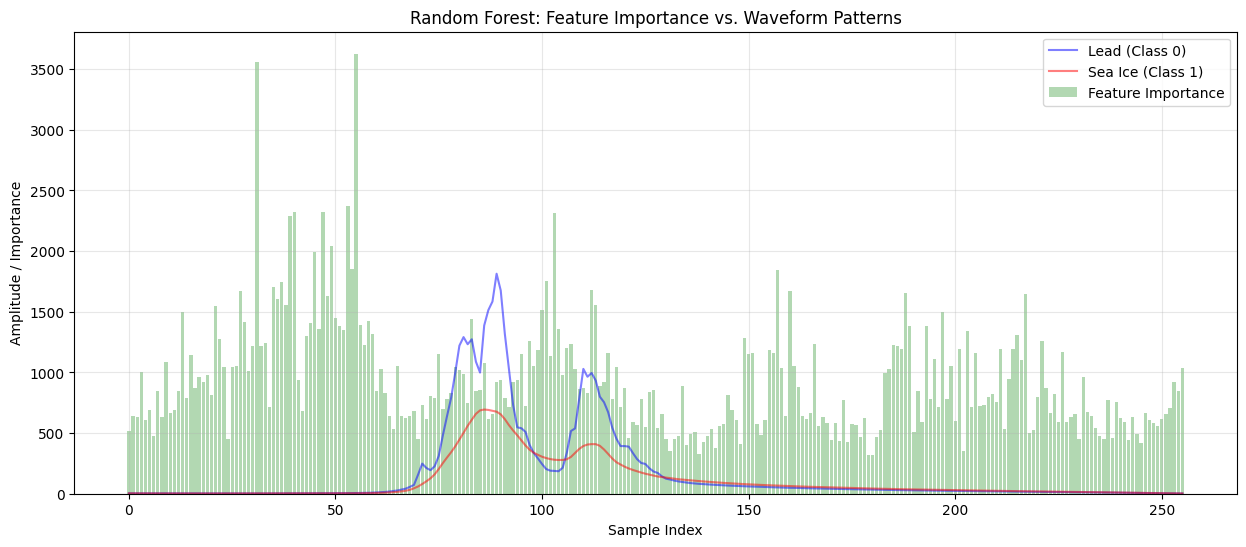

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("=== Training Random Forest Classifier ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Get feature importance
feature_importance_rf = rf_model.feature_importances_

# Plot feature importance on waveform
plot_importance_on_waveform(feature_importance_rf, 'Random Forest', X_clean, y_clean)

=== Training Gradient Boosting Classifier ===
Gradient Boosting Accuracy: 0.9593

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.26      0.37       121
           1       0.96      0.99      0.98      2432

    accuracy                           0.96      2553
   macro avg       0.83      0.63      0.68      2553
weighted avg       0.95      0.96      0.95      2553



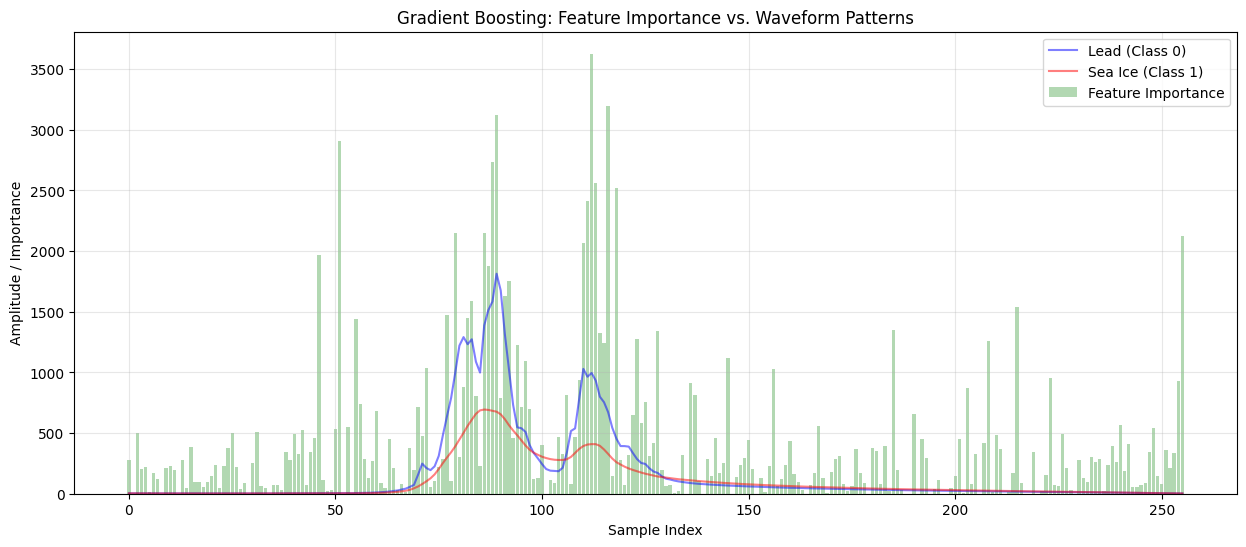

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

print("=== Training Gradient Boosting Classifier ===")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)

# Train the model
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

# Get feature importance
feature_importance_gb = gb_model.feature_importances_

# Plot feature importance on waveform
plot_importance_on_waveform(feature_importance_gb, 'Gradient Boosting', X_clean, y_clean)

=== Training XGBoost Classifier ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9573

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.21      0.32       121
           1       0.96      0.99      0.98      2432

    accuracy                           0.96      2553
   macro avg       0.81      0.60      0.65      2553
weighted avg       0.95      0.96      0.95      2553



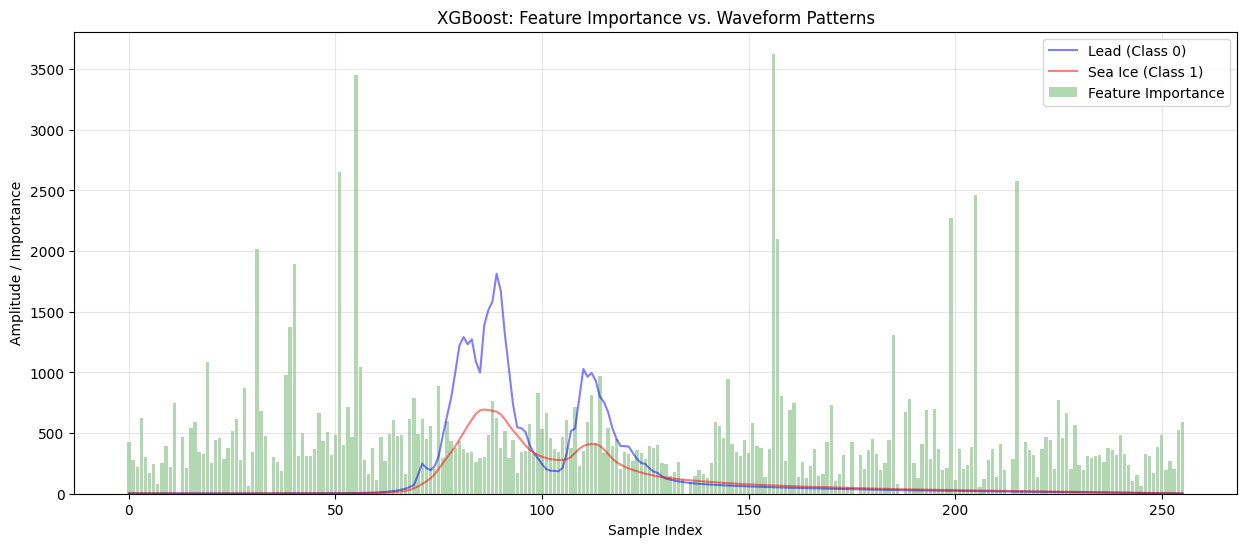

In [ ]:
import xgboost as xgb

print("=== Training XGBoost Classifier ===")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Get feature importance
feature_importance_xgb = xgb_model.feature_importances_

# Plot feature importance on waveform
plot_importance_on_waveform(feature_importance_xgb, 'XGBoost', X_clean, y_clean)